In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
df = pd.read_csv("train.csv")
df.head()

,ID,EC,OM,BD,P,SAND,SILT,CLAY,N,K,Ca,Mg,Na,CEC,SAR,ESP,Class.pH
0,31.12,1.4,2.4,1.4,21.0,65.5,16.7,17.8,0.0,0.4,3.1,2.9,0.4,8.9,0.1,0.0,Moderately acidic
1,2.00,0.4,1.3,1.3,10.5,18.2,30.0,51.8,0.1,2.1,54.1,3.4,5.9,40.7,0.2,0.1,Strongly alkaline
2,4.10,1.1,1.2,1.4,6.3,26.2,20.2,21.8,0.1,2.3,23.8,3.6,0.3,18.9,0.0,0.0,Moderately alkaline
3,6.00,0.4,3.2,1.3,4.2,32.9,26.0,41.1,0.1,1.8,91.5,10.6,0.2,36.3,0.0,0.0,Moderately alkaline
4,7.00,0.9,1.2,1.7,5.2,64.2,22.7,13.1,0.1,0.9,5.9,3.0,0.2,9.9,0.1,0.0,Moderately acidic


In [3]:
le = LabelEncoder()
df['Class.pH_encoded'] = le.fit_transform(df['Class.pH'])

for i, cls in enumerate(le.classes_):
    print(f"{i} = {cls}")

0 = Moderately acidic
1 = Moderately alkaline
2 = Neutral
3 = Strongly acidic
4 = Strongly alkaline
5 = nan


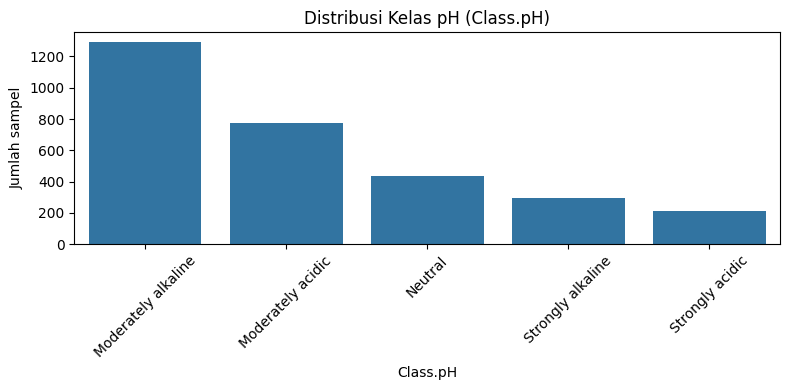

In [4]:
plt.figure(figsize=(8,4))
sns.countplot(x='Class.pH', data=df, order=df['Class.pH'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Kelas pH (Class.pH)")
plt.ylabel("Jumlah sampel")
plt.tight_layout()
plt.show()

In [5]:
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
ID,3022.0,2421.431099,1345.505169,1.1,1276.25,2370.50,3601.75,4768.00
EC,3017.0,1.109195,3.324244,0.0,0.30,0.40,0.80,65.40
OM,3019.0,3.124008,3.643582,0.1,1.50,2.30,3.60,37.90
BD,3016.0,2.213316,5.015036,0.5,1.30,1.30,1.40,31.12
P,2903.0,22.845532,40.721598,0.0,5.20,12.10,26.45,857.10
SAND,3021.0,37.125654,19.183357,0.8,21.50,34.90,51.50,100.00
SILT,3021.0,22.062469,10.304526,1.1,15.10,21.30,28.00,69.30
CLAY,3021.0,36.831314,16.862349,0.0,23.10,34.70,49.80,83.20
N,3014.0,0.502741,3.351938,0.0,0.10,0.10,0.10,31.12
K,3008.0,2.994927,7.071810,0.0,0.60,1.10,1.80,31.12


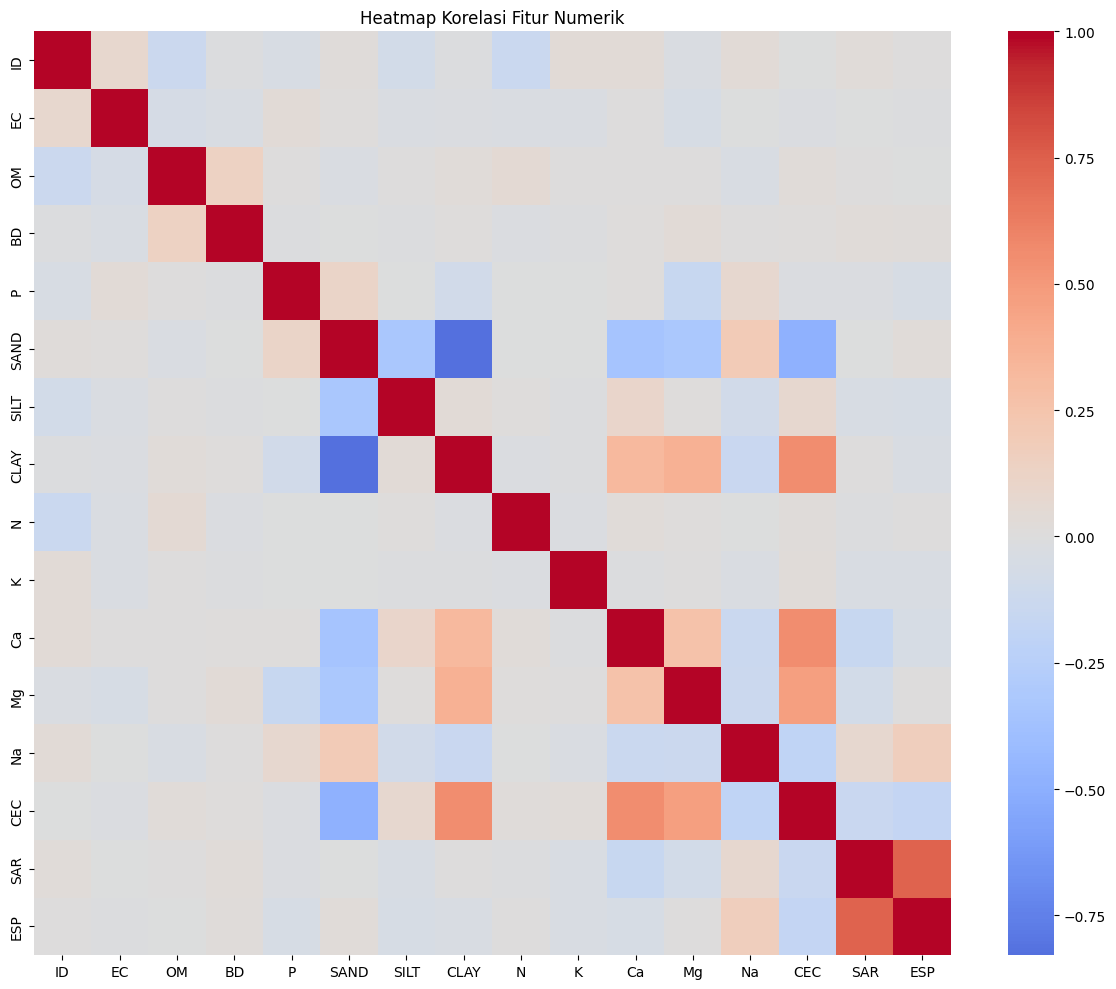

In [6]:
#Correlation heatmap 
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_cols = [c for c in numeric_cols if c != 'Class.pH_encoded']
plt.figure(figsize=(12,10))
corr = df[corr_cols].corr(method='pearson')
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Heatmap Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()

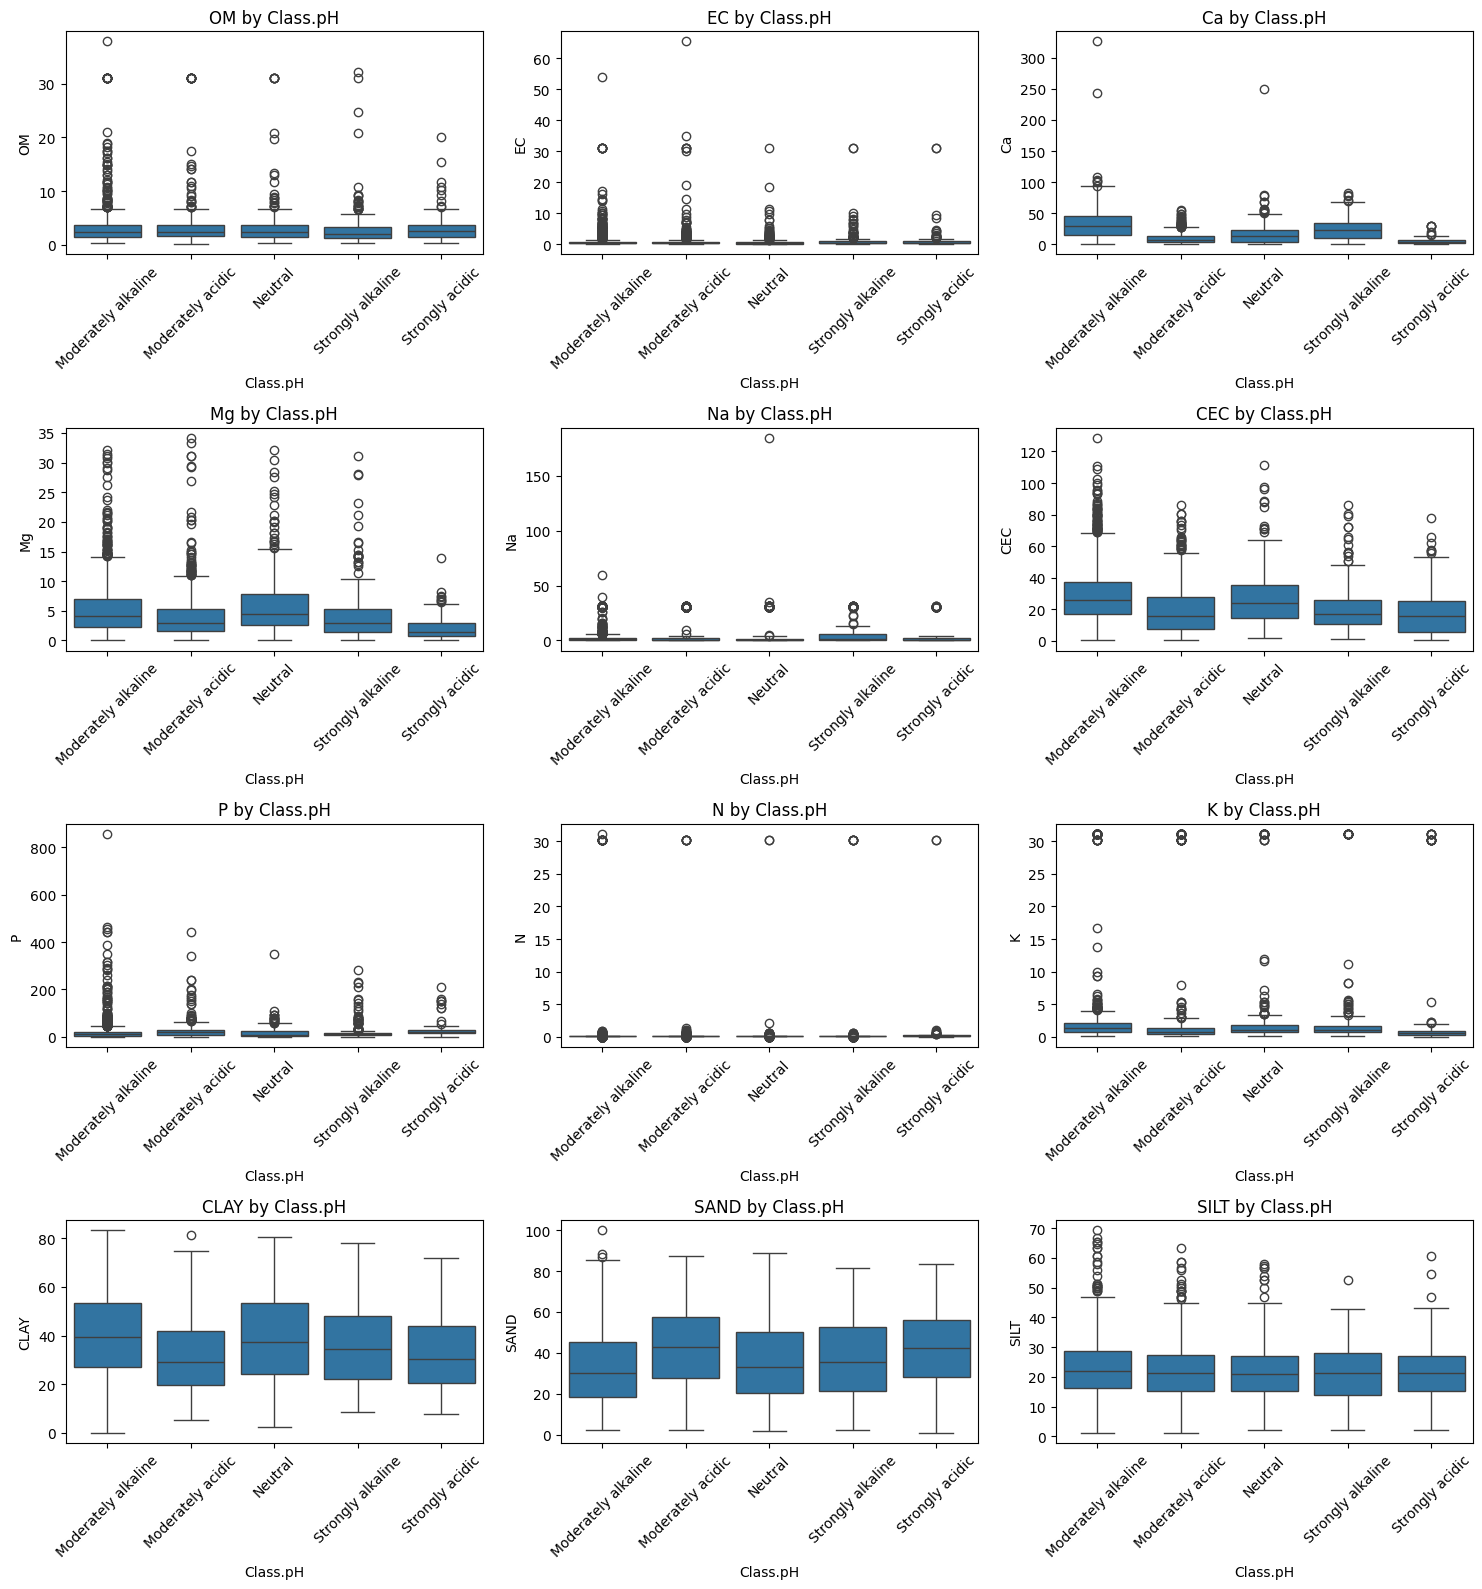

In [7]:
#Boxplots
features_to_plot = ['OM','EC','Ca','Mg','Na','CEC','P','N','K','CLAY','SAND','SILT']
features_to_plot = [f for f in features_to_plot if f in df.columns]
n = len(features_to_plot)
cols = 3
rows = int(np.ceil(n/cols))
plt.figure(figsize=(cols*5, rows*4))
for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x='Class.pH', y=feat, data=df, order=df['Class.pH'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"{feat} by Class.pH")
plt.tight_layout()
plt.show()


Pairplot features selected (by variance): ['ID', 'P', 'Ca', 'SAND']


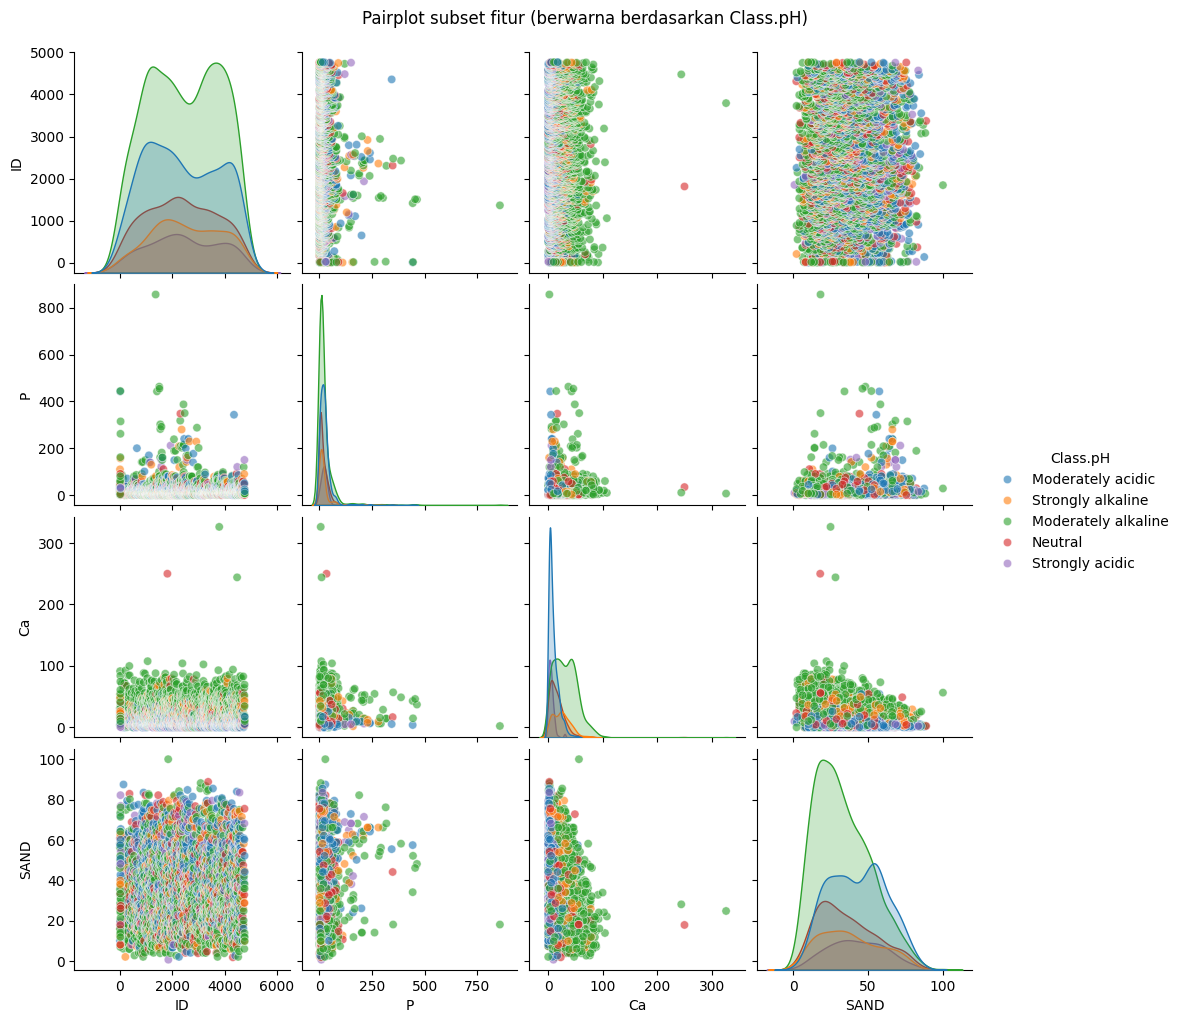

In [8]:
var_sorted = df[corr_cols].var().sort_values(ascending=False)
pair_feats = var_sorted.index[:4].tolist()
print("\nPairplot features selected (by variance):", pair_feats)
sns.pairplot(df[pair_feats + ['Class.pH']], hue='Class.pH', plot_kws={'alpha':0.6}, height=2.5)
plt.suptitle("Pairplot subset fitur (berwarna berdasarkan Class.pH)", y=1.02)
plt.show()

In [9]:
# Train models: RandomForest, XGBoost, Stacking
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [10]:
X = df.drop(columns=['Class.pH','Class.pH_encoded'])
y = df['Class.pH_encoded']

# Impute missing numeric values (median)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Train-test split (stratify by y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("\nAfter preprocessing - shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)



After preprocessing - shapes: (2417, 16) (605, 16) (2417,) (605,)


In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.54      0.70      0.61       155
           1       0.64      0.87      0.74       258
           2       0.18      0.06      0.09        88
           3       0.79      0.26      0.39        43
           4       0.44      0.07      0.12        59
           5       1.00      0.50      0.67         2

    accuracy                           0.59       605
   macro avg       0.60      0.41      0.43       605
weighted avg       0.54      0.59      0.52       605



In [14]:
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost:
               precision    recall  f1-score   support

           0       0.57      0.72      0.64       155
           1       0.67      0.83      0.74       258
           2       0.24      0.14      0.17        88
           3       0.57      0.19      0.28        43
           4       0.55      0.20      0.30        59
           5       0.00      0.00      0.00         2

    accuracy                           0.59       605
   macro avg       0.43      0.35      0.35       605
weighted avg       0.56      0.59      0.55       605



C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

# Meta model (Level-1) → bisa Logistic Regression (simple & explainable)
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,  
    cv=5               
)

# Train stacking
stack.fit(X_train, y_train)

# Predictions
y_pred_stack = stack.predict(X_test)

# Evaluation
print("Stacking Ensemble:\n", classification_report(y_test, y_pred_stack))

C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Stacking Ensemble:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63       155
           1       0.66      0.84      0.74       258
           2       0.28      0.09      0.14        88
           3       0.62      0.23      0.34        43
           4       0.56      0.24      0.33        59
           5       0.00      0.00      0.00         2

    accuracy                           0.60       605
   macro avg       0.45      0.36      0.36       605
weighted avg       0.56      0.60      0.55       605



C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\miniforge3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
#PERBANDINGAN KETIGA MODEL
def summary_scores(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

scores_rf = summary_scores(y_test, y_pred_rf)
scores_xgb = summary_scores(y_test, y_pred_xgb)
scores_stack = summary_scores(y_test, y_pred_stack)

results_df = pd.DataFrame([
    {'Model':'RandomForest', **scores_rf},
    {'Model':'XGBoost', **scores_xgb},
    {'Model':'Stacking', **scores_stack}
]).set_index('Model')

print("\nPerbandingan metrik model (test set):")
display(results_df)


Perbandingan metrik model (test set):


,Accuracy,Precision_macro,Recall_macro,F1_macro
Model,,,,
RandomForest,0.585124,0.597613,0.408645,0.433711
XGBoost,0.593388,0.432324,0.346952,0.354865
Stacking,0.600000,0.445690,0.355791,0.363223


<Figure size 800x400 with 0 Axes>

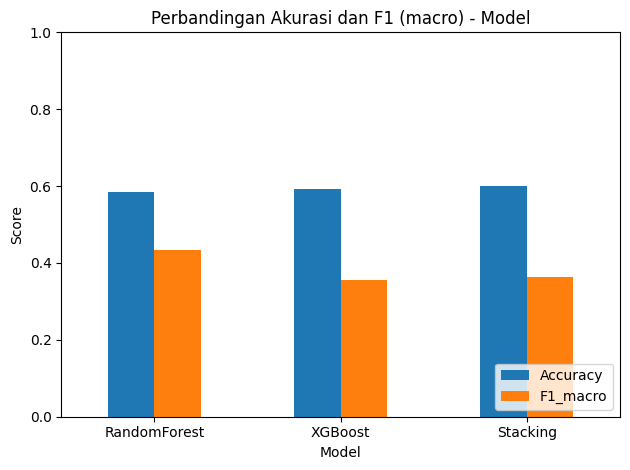

In [19]:
plt.figure(figsize=(8,4))
results_df[['Accuracy','F1_macro']].plot(kind='bar', rot=0)
plt.title("Perbandingan Akurasi dan F1 (macro) - Model")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

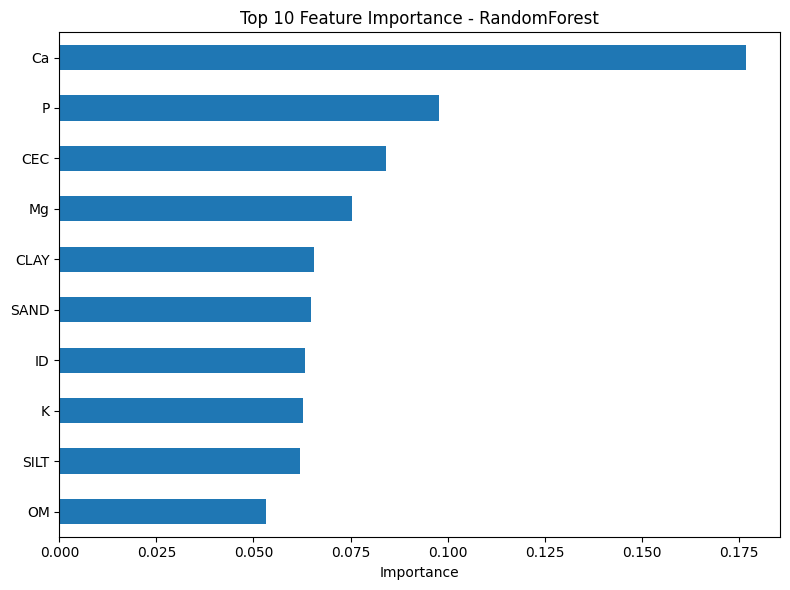

In [20]:
# Feature importance - RandomForest
feat_imp_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp_rf.tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importance - RandomForest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

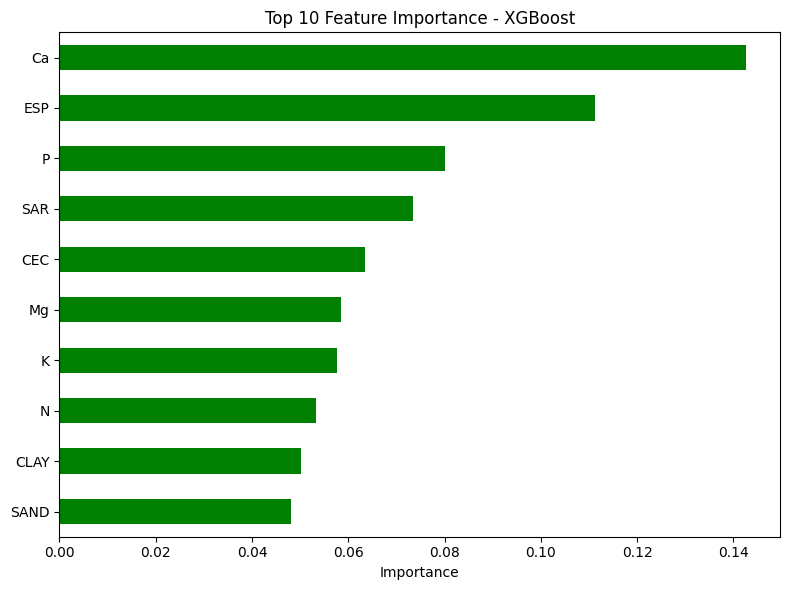

In [21]:
# Feature importance - XGBoost
feat_imp_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp_xgb.tail(10).plot(kind='barh', color='green')
plt.title("Top 10 Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
rf.fit(X_res, y_res)
xgb.fit(X_res, y_res)
stack.fit(X_res, y_res)

C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:16:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:16:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:16:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:16:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weig...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [24]:
from collections import Counter
print("Distribusi sebelum SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Distribusi sesudah SMOTE:", Counter(y_res))

Distribusi sebelum SMOTE: Counter({1: 1032, 0: 621, 2: 350, 4: 234, 3: 172, 5: 8})
Distribusi sesudah SMOTE: Counter({1: 1032, 3: 1032, 2: 1032, 0: 1032, 4: 1032, 5: 1032})


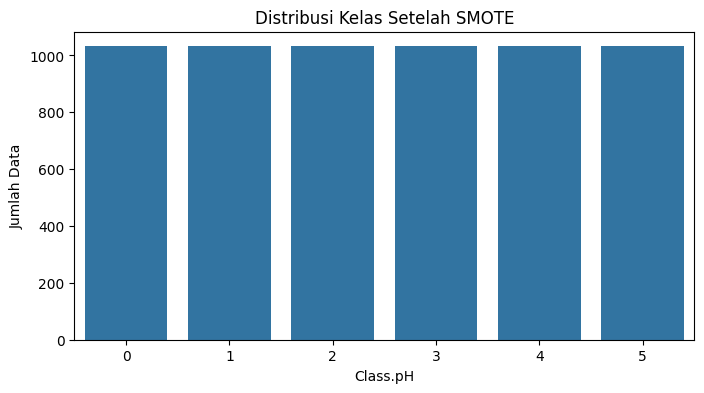

In [25]:
#Visualisasi distribusi kelas setelah SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x=y_res)
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Class.pH")
plt.ylabel("Jumlah Data")
plt.show()

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb.fit(X_res, y_res)
y_pred_xgb = xgb.predict(X_test)

# Stacking
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.1, eval_metric='mlogloss', random_state=42))
]
stack = StackingClassifier(estimators=estimators,
                           final_estimator=LogisticRegression(max_iter=1000),
                           cv=5,
                           n_jobs=-1)
stack.fit(X_res, y_res)
y_pred_stack = stack.predict(X_test)

In [27]:
def summary_scores(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_macro': precision_score(y_true, y_pred, average='macro'),
        'Recall_macro': recall_score(y_true, y_pred, average='macro'),
        'F1_macro': f1_score(y_true, y_pred, average='macro')
    }

results = []
results.append({'Model':'Random Forest', **summary_scores(y_test, y_pred_rf)})
results.append({'Model':'XGBoost', **summary_scores(y_test, y_pred_xgb)})
results.append({'Model':'Stacking Ensemble', **summary_scores(y_test, y_pred_stack)})

import pandas as pd
results_df = pd.DataFrame(results).set_index("Model")
print(results_df)

                   Accuracy  Precision_macro  Recall_macro  F1_macro
Model                                                               
Random Forest      0.581818         0.583250      0.569134  0.575160
XGBoost            0.590083         0.582190      0.477329  0.512238
Stacking Ensemble  0.595041         0.608545      0.474180  0.517236


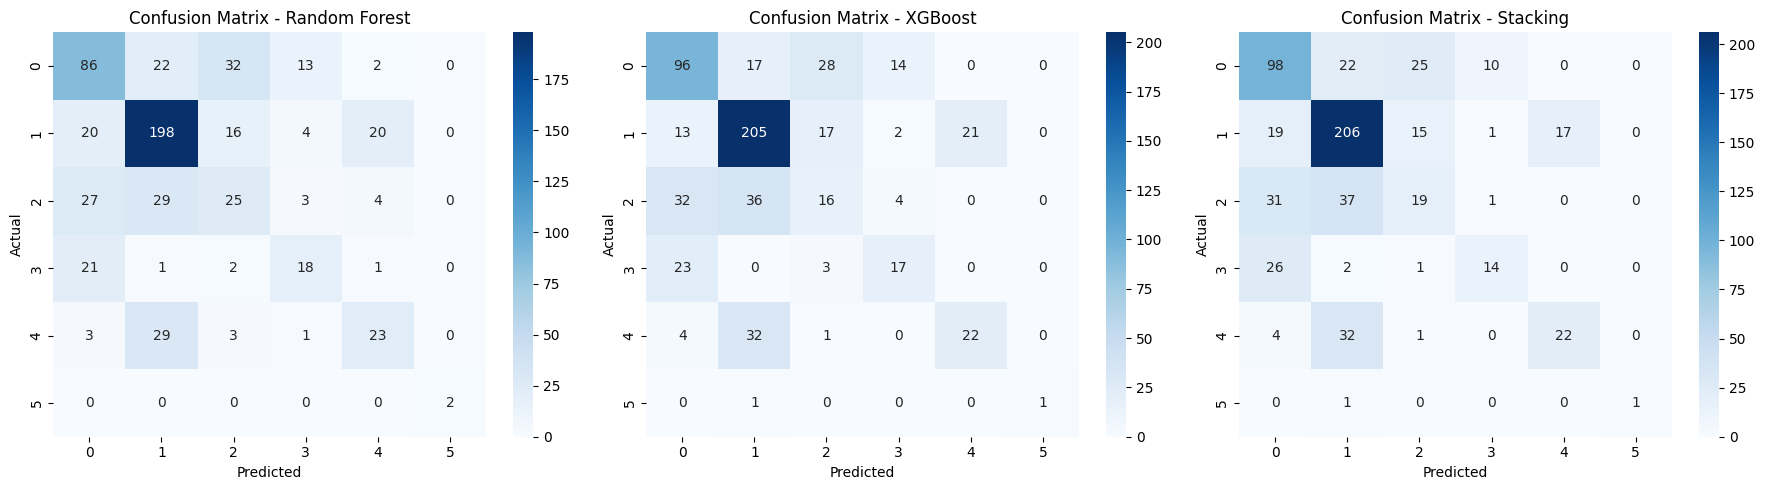

In [28]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax, y_pred, title in zip(axes,
                             [y_pred_rf, y_pred_xgb, y_pred_stack],
                             ['Random Forest','XGBoost','Stacking']):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()


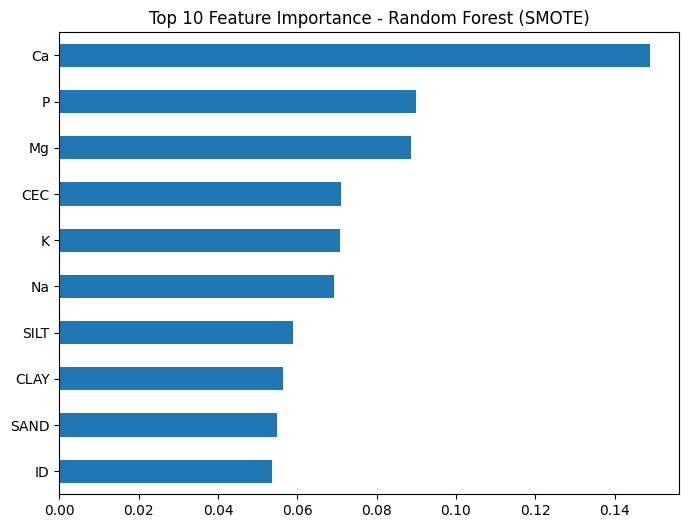

In [29]:
# RF Feature importance
feat_imp_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp_rf.tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importance - Random Forest (SMOTE)")
plt.show()

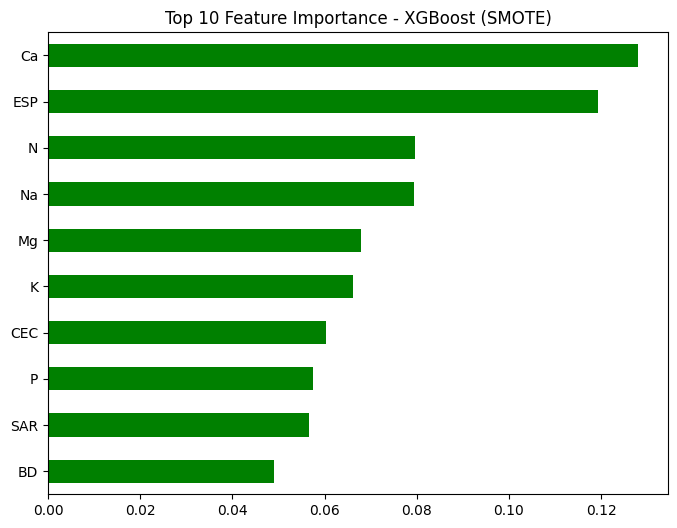

In [30]:
# XGB Feature importance
feat_imp_xgb = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
feat_imp_xgb.tail(10).plot(kind='barh', color='green')
plt.title("Top 10 Feature Importance - XGBoost (SMOTE)")
plt.show()

In [34]:
import shap

# --- Train ulang model (XGBoost) ---
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb.fit(X_res, y_res)  # pakai data setelah SMOTE

# --- SHAP Explainer ---
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

<Figure size 1000x600 with 0 Axes>

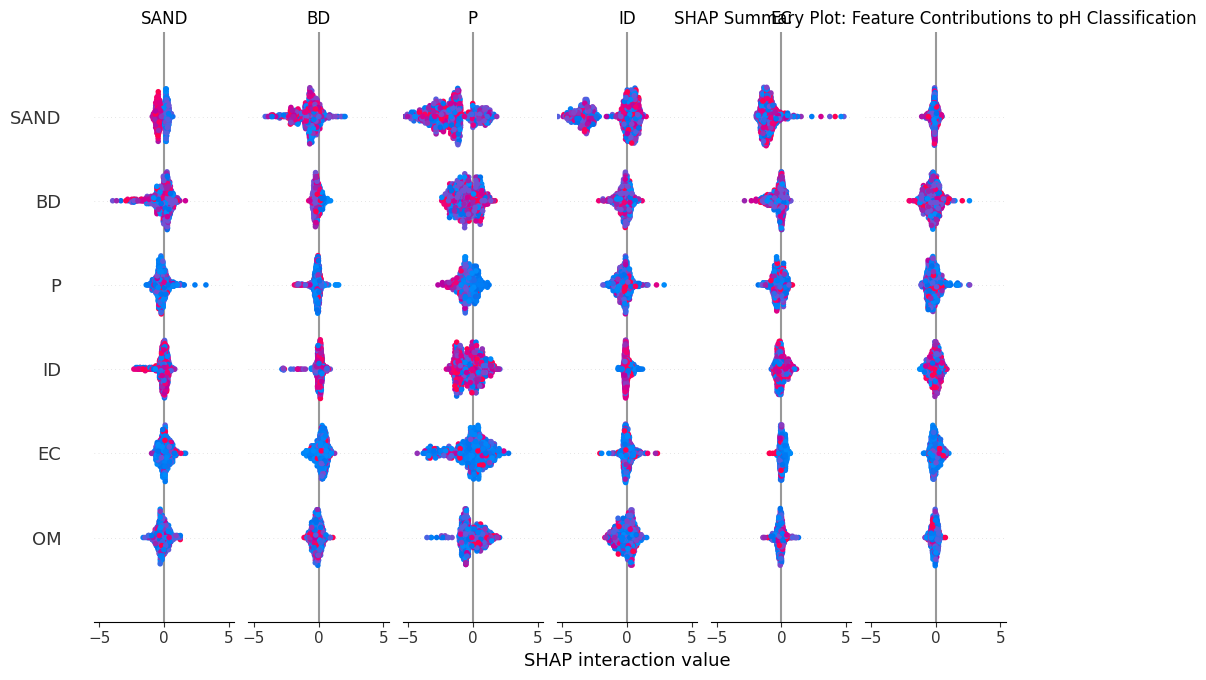

In [35]:
# --- Summary Plot ---
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Contributions to pH Classification")
plt.show()

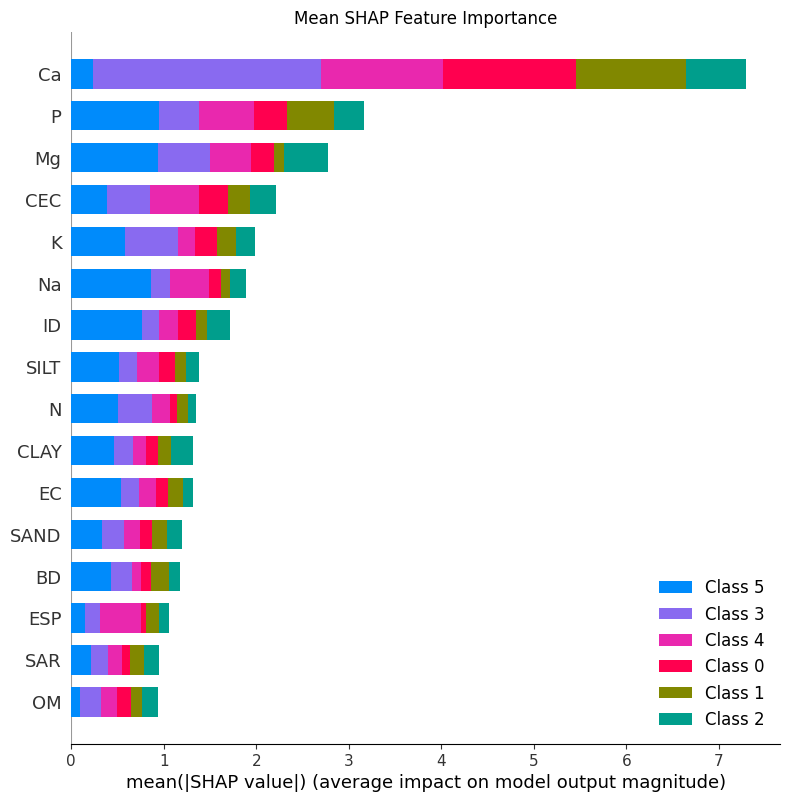

In [36]:

# --- Optional: Bar Plot SHAP Mean Importance ---
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Mean SHAP Feature Importance")
plt.show()